In [3]:
import sys
import os

py_file_location = "..."
sys.path.append(os.path.abspath(py_file_location))


In [4]:
from library import *
from model_DL import *
from functions import *
from metrics import *
from data_generator import *
from losses import *
from optimization import *
from parameters import *


In [5]:
### Train ###

dataset_train = np.load('Dataset/dataset_train.npz')
dataset_train.files
dataset_train = dataset_train['arr_0']

### Test ### 
dataset_test = np.load('Dataset/dataset_test_sigma_7_dim_10_vf.npz')
dataset_test.files
dataset_test = dataset_test['arr_0']

x_train = dataset_train[:,0:8]

x_test, y_test = dataset_test[:,0:8], dataset_test[:,8:12]



In [ ]:
model = tf.keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/CodeVF/model_train_VF_S7_D10/Lambda = 10_0.5/weights/10_-4.h5', custom_objects={'DF_loss':loss_DF(Lambda,tau),'Primary_Achievable_Rate_Degradation':Primary_Achievable_Rate_Degradation,'Primary_ARDP':Primary_ARD_Percentage,'throughput':Achievable_Rate(tau),'V_Qos':QoS_Violation(tau), "custom_sigmoid":custom_sigmoid})


In [ ]:
#yacine
n = 256
sampling = 10000
step_sampling = 100
x_min, x_max = p_min, 10
y_min, y_max = p_min, 10

def pdd(Grp, Gpp, Gsp, Alpha, Pr, Ps):
  """
      Parameters:
         Grp: 1D Array containing Alpha values.
         Gpp: 1D Array containing Gain between primary transmitter and primary receiver.
         Gsp: 1D Array containing Gain between secondary transmitter and primary receiver.
         Alpha: 1D Array containing Alpha values.
         Pr: 1D Array containing Power of relay.
         Ps: 1D Array containing Power of secondary network.
      
      Returns:
         primary debit degradation .

  """

  Rp = C((Gpp*Pp)/(Grp*Pr**2+Gsp*Ps**2+2*(np.sqrt(Gsp*Grp)*Ps*Pr*Alpha)+1))
  Rp_max = C(Gpp*Pp)
  ratio_Rp = np.nan_to_num((Rp_max-Rp)/Rp_max)
  return ratio_Rp

Rxx, Ryy = np.meshgrid(np.linspace(x_min, x_max, n),
                     np.linspace(y_min, y_max, n))

R = np.c_[Rxx.ravel(), Ryy.ravel()]


U_1 = np.ones((R.shape[0],2)) * np.array([0.25, 0.5])*10
D_1 = np.ones((R.shape[0],2)) * np.array([0.5, 0.75])*10
U_2 = np.ones((R.shape[0],2)) * np.array([0.5, 0.25])*10
D_2 = np.ones((R.shape[0],2)) * np.array([0.75, 0.5])*10

d_11 = np.linalg.norm(U_1 - D_1, axis=1)
d_12 = np.linalg.norm(U_1 - D_2, axis=1)
d_1R = np.linalg.norm(U_1 - R  , axis=1)
d_21 = np.linalg.norm(U_2 - D_1, axis=1)
d_22 = np.linalg.norm(U_2 - D_2, axis=1)
d_2R = np.linalg.norm(U_2 - R  , axis=1)
d_R1 = np.linalg.norm(R   - D_1, axis=1)
d_R2 = np.linalg.norm(R   - D_2, axis=1)

#d_11, d_12, d_1R, d_21, d_22, d_2R, , d_R2
D_test_R = np.c_[d_R1, d_11, d_2R, d_1R, d_22, d_R2, d_21, d_12].astype(np.float32)

#D_test_R = np.c_[d_11, d_12, d_1R, d_21, d_22, d_2R, d_R1, d_R2].astype(np.float32)

def channel_gain_with_gaussian_fading(d, sigma=7, alpha=3):  # channel gain model
    s = np.random.normal(0.0, sigma, d.shape)
    h = s/np.sqrt(1+np.power(d, alpha))
    g = h**2
    return g

P_R_mean = np.zeros(Rxx.shape)
P_S_mean = np.zeros(Rxx.shape)
aplha_mean = np.zeros(Rxx.shape)
D_mean = np.zeros(Rxx.shape)
S_mean = np.zeros(Rxx.shape)
pr_np = '/content/drive/MyDrive/Colab Notebooks/CodeVF/Relay_Plot/P_R_mean2'
ps_np = '/content/drive/MyDrive/Colab Notebooks/CodeVF/Relay_Plot/P_S_mean2'
alpha_np = '/content/drive/MyDrive/Colab Notebooks/CodeVF/Relay_Plot/alpha_mean2'
D_np = '/content/drive/MyDrive/Colab Notebooks/CodeVF/Relay_Plot/D_mean2'
S_np = '/content/drive/MyDrive/Colab Notebooks/CodeVF/Relay_Plot/S_mean2'

for i in range(int(sampling/step_sampling)):
    print(i)
    
    G = channel_gain_with_gaussian_fading((D_test_R[None,:,:]*np.ones((step_sampling,1,1))).reshape(-1,8), 7)
    Y = model.predict(G, batch_size = 4096)
    D = pdd(G[:,0], G[:,1], G[:,6], Y[:,0], Y[:,1], Y[:,2])
    S = debit(G[:,0], G[:,1], G[:,2], G[:,3], G[:,4], G[:,5], G[:,6], G[:,7], Y[:,0], Y[:,1], Y[:,2]) 
    S = S[:,8]
    del G
    alpha = Y[:,0]
    P_R = np.power(Y[:,1], 2)
    P_S = np.power(Y[:,2], 2)

    del Y
    P_R_mean = P_R_mean + np.sum(P_R.reshape((step_sampling,-1)),axis=0).reshape(Rxx.shape)
    P_S_mean = P_S_mean + np.sum(P_S.reshape((step_sampling,-1)),axis=0).reshape(Rxx.shape)
    aplha_mean = aplha_mean + np.sum(alpha.reshape((step_sampling,-1)),axis=0).reshape(Rxx.shape)
    D_mean = D_mean + np.sum(D.reshape((step_sampling,-1)),axis=0).reshape(Rxx.shape)
    S_mean = S_mean + np.sum(S.reshape((step_sampling,-1)),axis=0).reshape(Rxx.shape)   

    np.savez(pr_np, P_R_mean)
    np.savez(ps_np, P_S_mean)
    np.savez(alpha_np, aplha_mean)
    np.savez(D_np, D_mean)
    np.savez(S_np, S_mean)


P_R_mean = P_R_mean/sampling
P_S_mean = P_S_mean/sampling
aplha_mean = aplha_mean/sampling
D_mean = D_mean/sampling
S_mean = S_mean/sampling






0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in true_divide


17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


In [6]:

P_R_mean = np.load('Relay_Plot/P_R_mean2.npz')
P_S_mean = np.load('Relay_Plot/P_S_mean2.npz')
aplha_mean = np.load('Relay_Plot/alpha_mean2.npz')
D_mean = np.load('Relay_Plot/D_mean2.npz')
S_mean = np.load('Relay_Plot/S_mean2.npz')

P_R_mean.files
P_R_mean = P_R_mean['arr_0']

P_S_mean.files
P_S_mean = P_S_mean['arr_0']

aplha_mean.files
aplha_mean = aplha_mean['arr_0']

D_mean.files
D_mean = D_mean['arr_0']
S_mean.files
S_mean = S_mean['arr_0']

n = 256
sampling = 10000
step_sampling = 100
x_min, x_max = p_min, 10
y_min, y_max = p_min, 10

Rxx, Ryy = np.meshgrid(np.linspace(x_min, x_max, n),
                     np.linspace(y_min, y_max, n))

R = np.c_[Rxx.ravel(), Ryy.ravel()]


U_1 = np.ones((R.shape[0],2)) * np.array([0.25, 0.5])*10
D_1 = np.ones((R.shape[0],2)) * np.array([0.5, 0.75])*10
U_2 = np.ones((R.shape[0],2)) * np.array([0.5, 0.25])*10

D_2 = np.ones((R.shape[0],2)) * np.array([0.75, 0.5])*10

In [7]:
P_R_mean = P_R_mean/sampling
P_S_mean = P_S_mean/sampling
aplha_mean = aplha_mean/sampling
D_mean = D_mean/sampling
S_mean = S_mean/sampling

In [ ]:
'''
plt.figure()
plt.grid(False)


pos_min = p_min*10
pos_max = p_max*10
cax = plt.matshow(P_R_mean, origin='lower', extent=[pos_min, pos_max, pos_min, pos_max], cmap = 'viridis')
for v, l in ((U_1[0,:], "$U_P$"), (U_2[0,:], "$U_S$"), (D_1[0,:], "$D_P$"), (D_2[0,:], "$D_S$")):
        plt.grid(False)

        plt.scatter(v[0], v[1], marker="x", c='red')
        plt.annotate(l, (v[0]+0.2, v[1]), c='red')
plt.colorbar(cax, ticks=np.linspace(np.min(P_R_mean),np.max(P_R_mean),10))

plt.savefig('P_R.pdf', dpi=300)
plt.figure()
cax = plt.matshow(P_S_mean, origin='lower', extent=[pos_min, pos_max, pos_min, pos_max], cmap = 'viridis')
plt.colorbar(cax, ticks=np.linspace(np.min(P_S_mean),np.max(P_S_mean),10))
for v, l in ((U_1[0,:], "$U_1$"), (U_2[0,:], "$U_2$"), (D_1[0,:], "$D_1$"), (D_2[0,:], "$D_2$")):
        plt.grid(False)

        plt.scatter(v[0], v[1], marker="x", c='red')
        plt.annotate(l, (v[0]+0.2, v[1]), c='red')
#plt.title('$P_2$')
plt.xticks([])
plt.savefig('P_2.png', dpi=300)

plt.figure()
cax = plt.matshow(aplha_mean, origin='lower', extent=[pos_min, pos_max, pos_min, pos_max], cmap = 'viridis')

plt.colorbar(cax, ticks=np.linspace(np.min(aplha_mean),np.max(aplha_mean),10))
for v, l in ((U_1[0,:], "$U_1$"), (U_2[0,:], "$U_2$"), (D_1[0,:], "$D_1$"), (D_2[0,:], "$D_2$")):
        plt.grid(False)

        plt.scatter(v[0], v[1], marker="x", c='red')
        plt.annotate(l, (v[0]+0.2, v[1]), c='red')
#plt.title(r'$\alpha$')
plt.savefig('alpha.png', dpi=300)

plt.figure()

cax = plt.matshow(D_mean, origin='lower', extent=[pos_min, pos_max, pos_min, pos_max], cmap = 'viridis')
plt.colorbar(cax, ticks=np.linspace(np.min(D_mean),np.max(D_mean),10))
for v, l in ((U_1[0,:], "$U_P$"), (U_2[0,:], "$U_S$"), (D_1[0,:], "$D_P$"), (D_2[0,:], "$D_S$")):
        plt.grid(False)

        plt.scatter(v[0], v[1], marker="x", c='red')
        plt.annotate(l, (v[0]+0.2, v[1]), c='red')
#plt.title(r'$\alpha$') Pdd
plt.savefig('D_Mean.pdf', dpi=300)

'''

'\nplt.figure()\nplt.grid(False)\n\n\npos_min = p_min*10\npos_max = p_max*10\ncax = plt.matshow(P_R_mean, origin=\'lower\', extent=[pos_min, pos_max, pos_min, pos_max], cmap = \'viridis\')\nfor v, l in ((U_1[0,:], "$U_P$"), (U_2[0,:], "$U_S$"), (D_1[0,:], "$D_P$"), (D_2[0,:], "$D_S$")):\n        plt.grid(False)\n\n        plt.scatter(v[0], v[1], marker="x", c=\'red\')\n        plt.annotate(l, (v[0]+0.2, v[1]), c=\'red\')\nplt.colorbar(cax, ticks=np.linspace(np.min(P_R_mean),np.max(P_R_mean),10))\n\nplt.savefig(\'P_R.pdf\', dpi=300)\nplt.figure()\ncax = plt.matshow(P_S_mean, origin=\'lower\', extent=[pos_min, pos_max, pos_min, pos_max], cmap = \'viridis\')\nplt.colorbar(cax, ticks=np.linspace(np.min(P_S_mean),np.max(P_S_mean),10))\nfor v, l in ((U_1[0,:], "$U_1$"), (U_2[0,:], "$U_2$"), (D_1[0,:], "$D_1$"), (D_2[0,:], "$D_2$")):\n        plt.grid(False)\n\n        plt.scatter(v[0], v[1], marker="x", c=\'red\')\n        plt.annotate(l, (v[0]+0.2, v[1]), c=\'red\')\n#plt.title(\'$P_2$\')\n

$P_{S}$

<ipython-input-8-61f0b1854d9c>:11: MatplotlibDeprecationWarning: The 'cmap' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  cbar = plt.colorbar(cax, ticks=np.linspace(np.min(P_R_mean),np.max(P_R_mean),5), shrink=1, cmap = 'viridis')


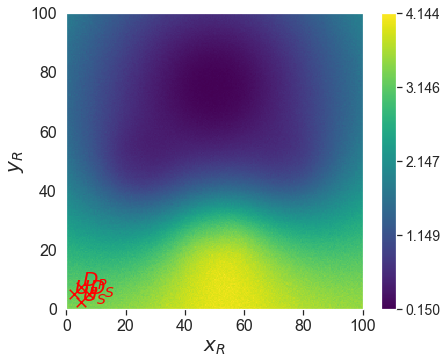

In [8]:
pos_min = p_min*10
pos_max = p_max*10

plt.figure(figsize=(6,4.8))
ax = plt.gca()
plt.tight_layout()
D_mean = D_mean*100

cax = ax.matshow(P_R_mean, origin='lower', extent=[pos_min, pos_max, pos_min, pos_max],cmap = 'viridis')
ax.xaxis.set_ticks_position('bottom')
cbar = plt.colorbar(cax, ticks=np.linspace(np.min(P_R_mean),np.max(P_R_mean),5), shrink=1, cmap = 'viridis')
for v, l in ((U_1[0,:], "$U_P$"), (U_2[0,:], "$U_S$"), (D_1[0,:], "$D_P$"), (D_2[0,:], "$D_S$")):
        plt.grid(False)
        plt.scatter(v[0], v[1], marker="x", c='red', s=90)
        plt.annotate(l, (v[0]+0.2, v[1]), c='red', fontsize=20)
for t in cbar.ax.get_yticklabels():
     t.set_fontsize(14)

plt.xlabel('$x_R$', fontsize=20)
plt.ylabel('$y_R$', fontsize=20)

plt.xticks(fontsize=16) 
plt.yticks(fontsize=16) 


plt.savefig('P_R.pdf', dpi=300, bbox_inches='tight')

$D_{Mean}$

<ipython-input-9-2533e2a557eb>:12: MatplotlibDeprecationWarning: The 'cmap' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  plt.colorbar(cax, ticks=np.linspace(np.min(D_mean),np.max(D_mean),5), shrink=1, cmap = 'viridis')


<Figure size 432x345.6 with 0 Axes>

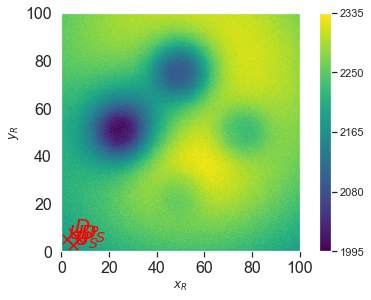

In [9]:
pos_min = p_min*10
pos_max = p_max*10
plt.figure(figsize=(6,4.8))

plt.figure()
ax = plt.gca()
plt.tight_layout()

D_mean = D_mean*100
cax = ax.matshow(D_mean, origin='lower', extent=[pos_min, pos_max, pos_min, pos_max],cmap = 'viridis')
ax.xaxis.set_ticks_position('bottom')
plt.colorbar(cax, ticks=np.linspace(np.min(D_mean),np.max(D_mean),5), shrink=1, cmap = 'viridis')
for v, l in ((U_1[0,:], "$U_P$"), (U_2[0,:], "$U_S$"), (D_1[0,:], "$D_P$"), (D_2[0,:], "$D_S$")):
        plt.grid(False)

        plt.scatter(v[0], v[1], marker="x", c='red', s=90)
        plt.annotate(l, (v[0]+0.2, v[1]), c='red', fontsize=20)
for t in cbar.ax.get_yticklabels():
     t.set_fontsize(14)

plt.xlabel('$x_R$')
plt.ylabel('$y_R$')
plt.xticks(fontsize=16) 
plt.yticks(fontsize=16) 

plt.savefig('D_Mean.pdf', dpi=300, bbox_inches='tight')

NameError: ignored

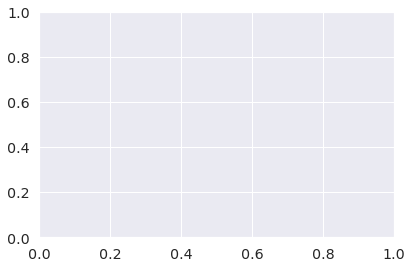

In [ ]:
pos_min = p_min*10
pos_max = p_max*10

plt.figure()
ax = plt.gca()
plt.tight_layout()
D_mean = D_mean*100
cax = ax.matshow(S_, origin='lower', extent=[pos_min, pos_max, pos_min, pos_max],cmap = 'viridis')
ax.xaxis.set_ticks_position('bottom')
plt.colorbar(cax, ticks=np.linspace(np.min(D_mean),np.max(D_mean),5), shrink=1, cmap = 'viridis')
for v, l in ((U_1[0,:], "$U_1$"), (U_2[0,:], "$U_2$"), (D_1[0,:], "$D_1$"), (D_2[0,:], "$D_2$")):
        plt.grid(False)

        plt.scatter(v[0], v[1], marker="x", c='red')
        plt.annotate(l, (v[0]+0.2, v[1]), c='red')
plt.xlabel('$x_R$')
plt.ylabel('$y_R$')
plt.xticks(fontsize=16) 
plt.yticks(fontsize=16) 

plt.savefig('D_Mean.pdf', dpi=300, bbox_inches='tight')

$S_{Mean}$

<ipython-input-10-17e8c5813a41>:9: MatplotlibDeprecationWarning: The 'cmap' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  cbar = plt.colorbar(cax, ticks=np.linspace(np.min(S_mean),np.max(S_mean),5), shrink=1, cmap = 'viridis')


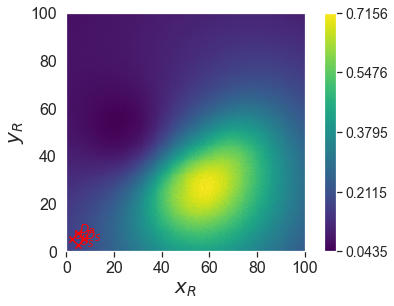

In [10]:
pos_min = p_min*10
pos_max = p_max*10
#sns.set(font_scale=5) 
plt.figure()
ax = plt.gca()
plt.tight_layout()
cax = ax.matshow(S_mean, origin='lower', extent=[pos_min, pos_max, pos_min, pos_max],cmap = 'viridis')
ax.xaxis.set_ticks_position('bottom')
cbar = plt.colorbar(cax, ticks=np.linspace(np.min(S_mean),np.max(S_mean),5), shrink=1, cmap = 'viridis')
for v, l in ((U_1[0,:], "$U_P$"), (U_2[0,:], "$U_S$"), (D_1[0,:], "$D_P$"), (D_2[0,:], "$D_S$")):
        plt.grid(False)
        plt.scatter(v[0], v[1], marker="x", c='red')
        plt.annotate(l, (v[0]+0.2, v[1]), c='red')
        
for t in cbar.ax.get_yticklabels():
     t.set_fontsize(14)

plt.xlabel('$x_R$', fontsize=20)
plt.ylabel('$y_R$', fontsize=20)
plt.xticks(fontsize=16) 
plt.yticks(fontsize=16) 

plt.savefig('S_Mean.pdf', dpi=300, bbox_inches='tight')

<ipython-input-11-bded6cfa85a0>:9: MatplotlibDeprecationWarning: The 'cmap' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  cbar = plt.colorbar(cax, ticks=np.linspace(np.min(S_mean),np.max(S_mean),5), shrink=1, cmap = 'viridis')


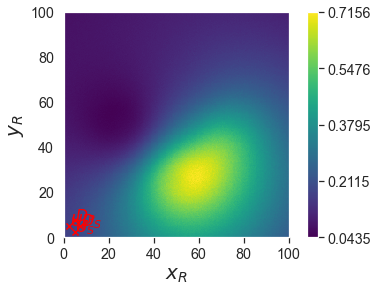

In [11]:
pos_min = p_min*10
pos_max = p_max*10
sns.set(font_scale=1.3) 
plt.figure()
ax = plt.gca()
plt.tight_layout()
cax = ax.matshow(S_mean, origin='lower', extent=[pos_min, pos_max, pos_min, pos_max],cmap = 'viridis')
ax.xaxis.set_ticks_position('bottom')
cbar = plt.colorbar(cax, ticks=np.linspace(np.min(S_mean),np.max(S_mean),5), shrink=1, cmap = 'viridis')
for v, l in ((U_1[0,:], "$U_P$"), (U_2[0,:], "$U_S$"), (D_1[0,:], "$D_P$"), (D_2[0,:], "$D_S$")):
        plt.grid(False)
        plt.scatter(v[0], v[1], marker="x", c='red')
        plt.annotate(l, (v[0]+0.2, v[1]), c='red')
        
plt.xlabel('$x_R$', fontsize=20)
plt.ylabel('$y_R$', fontsize=20)


plt.savefig('S_Mean.pdf', dpi=300, bbox_inches='tight')

In [ ]:
def ARD_mean(Grp, Gpp, Gsp, Alpha, Pr, Ps):
  """
    Mean of Primary achievable rate degradation.

    Parameters:
      Grp: 1D Array containing Channel Gain between relay and primary receiver.
      Gpp: 1D Array containing Channel Gain between primary transmitter and primary receiver.
      Gsp: 1D Array containing Channel Gain between secondary transmitter and primary receiver.
      Alpha: 1D Array containing Alpha values.
      Pr: 1D Array containing Power of relay.
      Ps: 1D Array containing Power of secondary network.

    Returns:
      Mean for Primary achievable rate degradation
  """
  res = pdd(Grp, Gpp, Gsp, Alpha, Pr, Ps)
  res = res[res>tau]
  with warnings.catch_warnings():
    warnings.filterwarnings('error')
    try:
        mean = np.nanmean(res)
    except RuntimeWarning:
        mean = 0
  return mean


In [ ]:
n = 256
sampling = 20000
step_sampling = 100
x_min, x_max = p_min, p_max
y_min, y_max = p_min, p_max

Rxx, Ryy = np.meshgrid(np.linspace(x_min, x_max, n),
                     np.linspace(y_min, y_max, n))

R = np.c_[Rxx.ravel(), Ryy.ravel()]


U_1 = np.ones((R.shape[0],2)) * np.array([0.25, 0.5])*10
D_1 = np.ones((R.shape[0],2)) * np.array([0.5, 0.75])*10
U_2 = np.ones((R.shape[0],2)) * np.array([0.5, 0.25])*10
D_2 = np.ones((R.shape[0],2)) * np.array([0.75, 0.5])*10

d_11 = np.linalg.norm(U_1 - D_1, axis=1)
d_12 = np.linalg.norm(U_1 - D_2, axis=1)
d_1R = np.linalg.norm(U_1 - R  , axis=1)
d_21 = np.linalg.norm(U_2 - D_1, axis=1)
d_22 = np.linalg.norm(U_2 - D_2, axis=1)
d_2R = np.linalg.norm(U_2 - R  , axis=1)
d_R1 = np.linalg.norm(R   - D_1, axis=1)
d_R2 = np.linalg.norm(R   - D_2, axis=1)
D_test_R = np.c_[d_11, d_12, d_1R, d_21, d_22, d_2R, d_R1, d_R2].astype(np.float32)

def channel_gain_with_gaussian_fading(d, sigma=7, alpha=3):  # channel gain model
    s = np.random.normal(0.0, sigma, d.shape)
    h = s/np.sqrt(1+np.power(d, alpha))
    g = h**2
    return g

P_R_mean = np.zeros(Rxx.shape)
P_S_mean = np.zeros(Rxx.shape)
aplha_mean = np.zeros(Rxx.shape)

for i in range(int(sampling/step_sampling)):
    print(i)
    G = channel_gain_with_gaussian_fading((D_test_R[None,:,:]*np.ones((step_sampling,1,1))).reshape(-1,8), sigma)
    Y = model.predict(G, batch_size = 4096)
    del G
    alpha = Y[:,0]
    P_R = np.power(Y[:,1], 2)
    P_S = np.power(Y[:,2], 2)
    del Y
    P_R_mean = P_R_mean + np.sum(P_R.reshape((step_sampling,-1)),axis=0).reshape(Rxx.shape)
    P_S_mean = P_S_mean + np.sum(P_S.reshape((step_sampling,-1)),axis=0).reshape(Rxx.shape)
    aplha_mean = aplha_mean + np.sum(alpha.reshape((step_sampling,-1)),axis=0).reshape(Rxx.shape)
P_R_mean = P_R_mean/sampling
P_S_mean = P_S_mean/sampling
aplha_mean = aplha_mean/sampling




In [ ]:
pos_min, pos_max = p_min, p_max

In [ ]:
plt.figure(figsize=(10,10))
cax = plt.matshow(P_R_mean, origin='lower', extent=[pos_min, pos_max, pos_min, pos_max])
for v, l in ((U_1[0,:], "$U_1$"), (U_2[0,:], "$U_2$"), (D_1[0,:], "$D_1$"), (D_2[0,:], "$D_2$")):
        plt.scatter(v[0], v[1], marker="x", c='r')
        plt.annotate(l, (v[0]+0.2, v[1]), c='r')
plt.colorbar(cax, ticks=np.linspace(np.min(P_R_mean),np.max(P_R_mean),10))
plt.title('$P_R$')
plt.savefig('P_R.png', dpi=300)
plt.figure(figsize=(10,10))
cax = plt.matshow(P_S_mean, origin='lower', extent=[pos_min, pos_max, pos_min, pos_max])
plt.colorbar(cax, ticks=np.linspace(np.min(P_S_mean),np.max(P_S_mean),10))
for v, l in ((U_1[0,:], "$U_1$"), (U_2[0,:], "$U_2$"), (D_1[0,:], "$D_1$"), (D_2[0,:], "$D_2$")):
        plt.scatter(v[0], v[1], marker="x", c='r')
        plt.annotate(l, (v[0]+0.2, v[1]), c='r')
plt.title('$P_2$')
plt.savefig('P_2.png', dpi=300)
plt.figure(figsize=(10,10))
cax = plt.matshow(aplha_mean, origin='lower', extent=[pos_min, pos_max, pos_min, pos_max])
plt.colorbar(cax, ticks=np.linspace(np.min(aplha_mean),np.max(aplha_mean),10))
for v, l in ((U_1[0,:], "$U_1$"), (U_2[0,:], "$U_2$"), (D_1[0,:], "$D_1$"), (D_2[0,:], "$D_2$")):
        plt.scatter(v[0], v[1], marker="x", c='r')
        plt.annotate(l, (v[0]+0.2, v[1]), c='r')
plt.title(r'$\alpha$')
plt.savefig('alpha.png', dpi=300)

In [ ]:
def relative_avreage_gap(X, Y):
  """relative avreage gap between the predicted debit and the obtained debit based on bruteforce"""

  return (np.mean(X) - np.mean(Y))/(np.mean(Y))


In [ ]:
# modified part


LD = {'10_-1':10**-1,'10_-0.75':10**-0.75,'10_-0.5':10**-0.5,'10_-0.25':10**-0.25,'10_0':10**0,'10_0.25':10**0.25,'10_0.5':10**0.5,'10_0.75':10**0.75,'10_1':10**1,'10_1.25':10**1.25,'10_1.5':10**1.5,'10_1.75':10**1.75,'10_2':10**2}

LR = {'10_-4':10**-4}


predicted_debit = []
predicted_debit_all = []
debit_gap, debit_gap_all = np.array([]), []

pdd_vmin, pdd_vmax, pdd_vmean, pdd_vstd = np.array([]), np.array([]), np.array([]), np.array([])
pdd_vmin_all, pdd_vmax_all, pdd_vmean_all, pdd_vstd_all = [], [], [], []
ard_mean, ard_mean_all = np.array([]), []

viloated_tau, viloated_tau_all = np.array([]), []

for ld_k in LD.keys():

  for lr_k in LR.keys():

      model = tf.keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/CodeVF/model_train_VF_S7_D10/Lambda = '+ld_k+'/weights/'+lr_k+'.h5', custom_objects={'DF_loss':loss_DF(Lambda,tau),'Primary_Achievable_Rate_Degradation':Primary_Achievable_Rate_Degradation,'Primary_ARDP':Primary_ARD_Percentage,'throughput':Achievable_Rate(tau),'V_Qos':QoS_Violation(tau), "custom_sigmoid":custom_sigmoid})

      ##### Evaluation on test set #####
      predictions = model.predict(x_test)
    
      # debit calculation for ground truth and predicted test set
      debit_hat_test = debit(x_test[:,0], x_test[:,1], x_test[:,2], x_test[:,3],x_test[:,4], x_test[:,5], x_test[:,6], x_test[:,7], predictions[:,0], predictions[:,1], predictions[:,2])
      debit_true_test = dataset(x_test[:,0], x_test[:,1], x_test[:,2], x_test[:,3],x_test[:,4], x_test[:,5], x_test[:,6], x_test[:,7], y_test[:,0], np.sqrt(y_test[:,1]), np.sqrt(y_test[:,2]), np.sqrt(y_test[:,3]))

      
      #predicted debit
  
      predicted_debit.append(debit_hat_test[:,8]) 
     
      ###### Gap Acheivable rate ######
      #Avreage debit gap between predicted and Brutefroce debit
      debit_gap = np.append(debit_gap, relative_avreage_gap(debit_hat_test[:,8], debit_true_test[:,8])) #[:,7] : extracting debit from ND array

      ###### Primary degradation Violation ######
      #  Primary degradation percentage, mean and median calculation
      # qos_violation calculation
      tau_violation_count = Tau_Violation_Number(x_test[:,0], x_test[:,1], x_test[:,6], predictions[:,0], predictions[:,1], predictions[:,2]) 

      viloated_tau = np.append(viloated_tau, Tau_Violation_percentage(x_test, tau_violation_count))
      ard_mean = np.append(ard_mean, ARD_mean(x_test[:,0], x_test[:,1], x_test[:,6], predictions[:,0], predictions[:,1], predictions[:,2]))

      # min, max, mean and std for primary debit degradation
      pdd_vmin, pdd_vmax, pdd_vmean, pdd_vstd =  np.append(pdd_vmin,pdd_min(x_test[:,0], x_test[:,1], x_test[:,6], predictions[:,0], predictions[:,1], predictions[:,2])), np.append(pdd_vmax,pdd_max(x_test[:,0], x_test[:,1], x_test[:,6], predictions[:,0], predictions[:,1], predictions[:,2])), np.append(pdd_vmean, pdd_mean(x_test[:,0], x_test[:,1], x_test[:,6], predictions[:,0], predictions[:,1], predictions[:,2])), np.append(pdd_vstd,pdd_std(x_test[:,0], x_test[:,1], x_test[:,6], predictions[:,0], predictions[:,1], predictions[:,2]))  
  # append data from the temporary list to the principal list
  debit_gap_all.append(debit_gap)

  predicted_debit_all.append(predicted_debit)
  ard_mean_all.append(ard_mean)

  viloated_tau_all.append(viloated_tau)
  pdd_vmin_all.append(pdd_vmin)
  pdd_vmax_all.append(pdd_vmax)
  pdd_vmean_all.append(pdd_vmean)
  pdd_vstd_all.append(pdd_vstd)

  # empty temporary lists
  predicted_debit = []
  debit_gap, viloated_tau = np.array([]), np.array([])

  pdd_vmin, pdd_vmax, pdd_vmean, pdd_vstd = np.array([]), np.array([]), np.array([]), np.array([])
  ard_mean = np.array([])

In [ ]:
np.array(debit_gap_all).transpose().reshape(13)

In [ ]:
from matplotlib import pyplot as plt


A = np.array([10**-1,10**-0.75,10**-0.5,10**-0.25,10**0,10**0.25,10**0.5,10**0.75,10**1,10**1.25,10**1.5,10**1.75,10**2])

A= np.round(A, decimals=4)

B = np.array(debit_gap_all).transpose().reshape(13)

B = np.round(B, decimals=4)

C = np.array(viloated_tau_all).transpose().reshape(13)

C = np.round(C, decimals=4)

D = np.array(pdd_vmean_all).transpose().reshape(13)
D = np.round(D, decimals=4)

E = np.array(pdd_vmax_all).transpose().reshape(13)

E = np.round(pdd_vmax_all, decimals=4)

Mean_PDD = np.array(ard_mean_all).transpose().reshape(13)

Mean_PDD = np.round(ard_mean_all, decimals=4)


In [ ]:
def percentage(x):
  x = np.array(x)*100
  x = x.tolist()
  return x
  

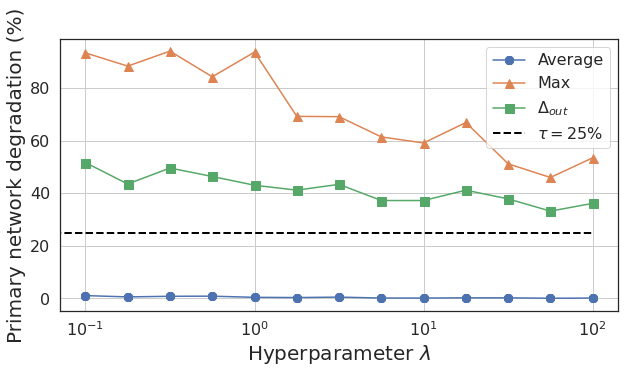

In [ ]:
plt.rcParams["figure.figsize"] = (10,5)
import seaborn as sns;
#sns.set_theme(color_codes=True)
sns.set(style='white')
fig = plt.figure(1)

plt.grid()
xs = np.linspace(1, 21, 100)

plt.hlines(y=25, xmin=0, xmax=len(xs), colors='black', linestyles='--', lw=2, label=r'$\tau = 25\%$')

plt.plot(A,D*100, label = 'Average', marker='8',markersize=9)

plt.plot(A,E*100, label= 'Max', marker='^',markersize=9)
plt.plot(A,Mean_PDD*100, label= r'$\Delta_{out}$', marker='s',markersize=9)

#plt.yscale('log')
plt.xscale('log')
plt.xlabel(r'Hyperparameter $\lambda$',fontsize= 20)
plt.ylabel('Primary network degradation (%)',fontsize= 20)
plt.xticks(fontsize=16) 
plt.yticks(fontsize=16) 
#plt.xticks(A,['$10^{-1}$', '$10^{-0.75}$','$10^{-0.5}$', '$10^{-0.25}$','$10^{0}$', '$10^{0.25}$','$10^{0.5}$', '$10^{0.75}$','$10^{1}$','$10^{1.25}$','$10^{1.5}$','$10^{1.75}$','$10^{2}$'])
plt.legend(loc = 'best', fontsize= 16)
fig.savefig('stats.pdf', bbox_inches='tight')


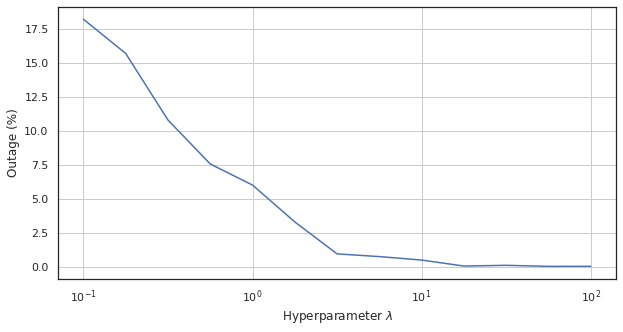

In [ ]:
plt.rcParams["figure.figsize"] = (10,5)

sns.set(style='white')
fig = plt.figure(1)

plt.grid()
xs = np.linspace(1, 21, 100)

plt.plot(A,C, label = 'Outage')

plt.ylabel('Outage (%)')
plt.xscale('log')
plt.xlabel(r'Hyperparameter $\lambda$')

#plt.xticks(A,['$10^{-1}$', '$10^{-0.75}$','$10^{-0.5}$', '$10^{-0.25}$','$10^{0}$', '$10^{0.25}$','$10^{0.5}$', '$10^{0.75}$','$10^{1}$','$10^{1.25}$','$10^{1.5}$','$10^{1.75}$','$10^{2}$'])
#plt.legend(loc = 'best')
fig.savefig('outage.png', bbox_inches='tight')


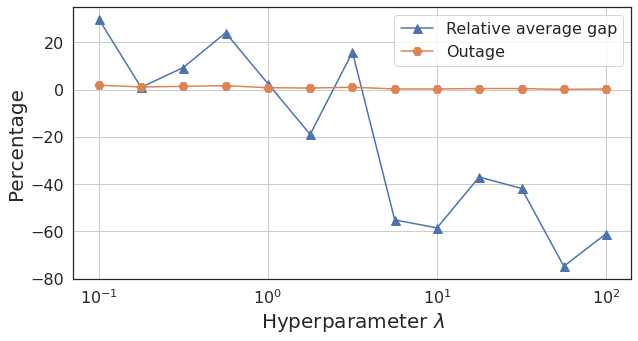

In [ ]:
plt.rcParams["figure.figsize"] = (10,5)

sns.set(style='white')
fig = plt.figure(1)

plt.grid()
xs = np.linspace(1, 21, 100)

plt.plot(A,B*100, label='Relative average gap', marker='^',markersize=9)
plt.plot(A,C, label = 'Outage', marker='H',markersize=9)

plt.ylabel('Percentage', fontsize= 20)
plt.xscale('log')
plt.xlabel(r'Hyperparameter $\lambda$',fontsize= 20)
plt.xticks(fontsize=16) 
plt.yticks(fontsize=16) 


#plt.xticks(A,['$10^{-1}$', '$10^{-0.75}$','$10^{-0.5}$', '$10^{-0.25}$','$10^{0}$', '$10^{0.25}$','$10^{0.5}$', '$10^{0.75}$','$10^{1}$','$10^{1.25}$','$10^{1.5}$','$10^{1.75}$','$10^{2}$'])
plt.legend(loc = 'best', fontsize= 16)
fig.savefig('RAG.pdf', bbox_inches='tight')


In [ ]:
#plt.plot(A,B, label = 'Acheivable rate relative gap ', marker='p')
plt.plot(A,C, label = 'Outage', marker='P')


In [ ]:
B

In [ ]:
B = np.array(debit_gap_all).transpose().reshape(13)
B


In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(2,2)

ax[0, 0].plot(range(10), 'r') #row=0, col=0
#ax[1, 0].plot(range(10), 'b') #row=1, col=0
ax[0, 1].plot(range(10), 'g') #row=0, col=1
#ax[1, 1].plot(range(10), 'k') #row=1, col=1
plt.show()


In [ ]:
LD = ['$10^{-1}$', '$10^{-0.75}$','$10^{-0.5}$', '$10^{-0.25}$','$10^{0}$', '$10^{0.25}$','$10^{0.5}$', '$10^{0.75}$','$10^{1}$','$10^{1.25}$','$10^{1.5}$','$10^{1.75}$','$10^{2}$']
LR = {'$10^{-4}$'}

In [ ]:
from matplotlib.colors import ListedColormap

def results_grid(title, data, lambda_label, lr_label):
  #df = pd.DataFrame(data, list(lambda_label.keys()), list(lr_label.keys()))
  df = pd.DataFrame(data, lambda_label, lr_label)

  fig, ax = plt.subplots(figsize=(10,10))
  plt.title(title)
  ax = sns.heatmap(df, annot=True, linewidths=.5, ax=ax)
  #ax = sns.boxplot(data=df, linewidth=2.5)
  plt.ylabel('Lambda')
  plt.xlabel('Learning rate')
  ax.set_yticklabels(ax.get_yticklabels(), rotation = 0, fontsize = 10)
  plt.savefig(title, bbox_inches='tight')


################ Acheivable rate results ################

results_grid('Acheivable rate avreage gap',debit_gap_all, LD, LR)

################ QoS results ################
results_grid('Percentage of Primary throughput degradation',viloated_tau_all, LD, LR)

################ Primary achievable rate degradation results ################

results_grid('Mean of primary achievable rate degradation',pdd_vmean_all, LD, LR)
results_grid('Min of primary achievable rate degradation',pdd_vmin_all, LD, LR)
results_grid('Max of primary achievable rate degradation',pdd_vmax_all, LD, LR)
results_grid('Std of primary achievable rate degradation',pdd_vstd_all, LD, LR)




In [ ]:
np.array(debit_gap_all).shape

In [ ]:
debit_true = dataset(x_test[:,0], x_test[:,1], x_test[:,2], x_test[:,3],x_test[:,4], x_test[:,5], x_test[:,6], x_test[:,7], y_test[:,0], np.sqrt(y_test[:,1]), np.sqrt(y_test[:,2]), np.sqrt(y_test[:,3]))

In [ ]:
LD = {'10_-1':10**-1,'10_-0.75':10**-0.75,'10_-0.5':10**-0.5,'10_-0.25':10**-0.25,'10_0':10**0,'10_0.25':10**0.25,'10_0.5':10**0.5,'10_0.75':10**0.75,'10_1':10**1,'10_1.25':10**1.25,'10_1.5':10**1.5,'10_1.75':10**1.75,'10_2':10**2}

LR = {'10_-4':10**-4}


def CDB(x, y, debit_GT):
  sns.set(style='white')
  plt.rcParams["figure.figsize"] = (10,5)
  
  colors = ['plum', 'green', 'aqua', 'wheat', 'darkred', 'grey', 'peru', 'purple', 'black', 'red']
  m = ['P','o', 'v', '^', '<', '>', 'H', '8', 'p','s']
  marker_N = 20000

  fig = plt.figure(1)
  #sns.ecdfplot(data=x[0,0,:], label=r'Proposed method ($\lambda = 10^{-1}$)', lw=1, ls='dashed', marker='^',markerfacecolor='darkred', dash_capstyle='round',color = 'black', markersize=9, markevery=marker_N)

  sns.ecdfplot(data=x[6,0,:], label=r'Proposed method ($\lambda = 10^{0.5}$)', lw=1, ls='solid', marker='^',markerfacecolor='plum', dash_capstyle='round',color = 'black', markersize=9, markevery=marker_N)
  sns.ecdfplot(data=x[12,0,:], label=r'Proposed method ($\lambda = 10^{2}$)', lw=1, ls='solid', marker='o',markerfacecolor='wheat', dash_capstyle='round',color = 'black', markersize=9, markevery=marker_N)

  sns.ecdfplot(data=debit_GT[:,8], label='Bruteforce', lw=1, ls='solid', marker='s',markerfacecolor='red', dash_capstyle='round',color = 'black', markersize=9, markevery=marker_N)

  plt.grid()
  plt.xlabel("Achievable rate $(bit/s/Hz)$", fontsize= 15)
  plt.ylabel("CDF", fontsize= 15)
  
  #plt.title('Cumulative distribution function',fontweight="bold")
  lgd = plt.legend(loc=4,
          fancybox=True, shadow=True, fontsize= 13)

  fig.savefig('CDB_vf.png', bbox_extra_artists=(lgd,), bbox_inches='tight')
  fig.show()


In [ ]:
CDB(np.array(predicted_debit_all), list(LR.keys()),debit_true)

In [ ]:
np.array(predicted_debit_all).shape

In [ ]:
def plot_learning_curve(title, data, val_data, ylab, x_lim, y_lim, Ld, Lr, filename):
  """
      Parameters:
         title : title of the figure (figure will be saved same as title)
         data: 1D array contains learning data history.
         ylab: y label.
         x_lim: set the x limits of the current axes.
         y_lim : set the y-limits of the current axes.
         filename : name of the file or path created to store figures.
      Returns:
         Plot for Achievable rate, Loss, Primary rate degradation and Qos violation evolution.
  """

  sns.set(style='white')
  plt.rcParams["figure.figsize"] = (10,5)

  colors = ['green', 'aqua', 'wheat', 'darkred', 'grey', 'peru', 'purple', 'black', 'plum']
  marker = ['-.',':','--','-']
  m = ['o', 'v', '^', '<', '>', 'H', '8', 'p','s','1','2','3','4','_','D','|','x','h','v']

  #plt.title(title, fontweight="bold")
  # plum, wheat, red
  
  plt.plot(data[0][0][:], label=r'Training set ($\lambda = 10^{0.5}$)',ls='solid', lw=1
  ,markerfacecolor='plum',dash_capstyle='round',color = 'black',marker='D', markersize=9, markevery=50)
  plt.plot(val_data[0][0][:], label='Validation set ($\lambda = 10^{0.5}$)',ls='-.', lw=0.4,marker='^',markerfacecolor='plum',dash_capstyle='round',color = 'black', markersize=9, markevery=50)

  plt.plot(data[1][0][:], label=r'Training set ($\lambda = 10^{2}$)',ls='dotted',marker='o' ,lw=1,markerfacecolor='wheat',dash_capstyle='round',color = 'black', markersize=9, markevery=50)
  plt.plot(val_data[1][0][:], label=r'Validation set ($\lambda = 10^{2}$)',ls='-.', lw=0.4,marker='P',markerfacecolor='wheat',dash_capstyle='round',color = 'black', markersize=9, markevery=50)

  fig = plt.figure(1)
  plt.xlabel("Epochs", fontsize= 20)
  plt.grid()
  plt.ylabel(ylab, fontsize= 20)
  plt.xlim(x_lim)
  plt.ylim(y_lim)
  lgd = plt.legend(loc='best', fontsize= 16)#title="Learning rate"

  plt.xticks(fontsize=16) 
  plt.yticks(fontsize=16) 
  
  fig.savefig(title+'_vf''.pdf', bbox_extra_artists=(lgd,), bbox_inches='tight')
  plt.show()
  plt.ion()
  plt.pause(1)
  plt.close()  



In [ ]:
LD = {'10_0.5':10**0.5,'10_2':10**2}

LR = {'10_-4':10**-4}


Loss_temp, Loss_data = [], []

Throughput_temp, Throughput_data = [], []

V_Qos_temp, V_Qos_data = [], []

Rp_degradation_temp, Rp_degradation_data = [], []


for ld_k in LD.keys():
  for lr_k in LR.keys():
  
    history = np.load('/content/drive/MyDrive/Colab Notebooks/CodeVF/model_train_VF_S7_D10/Lambda = '+ld_k+'/history/'+lr_k+'.npy',allow_pickle='TRUE').item()
    
    Loss_temp.append(history['loss'])
    Throughput_temp.append(history['throughput'])# Achievable_Rate
    V_Qos_temp.append(history['Primary_ARDP'])# Primary_ARDP
    Rp_degradation_temp.append(history['Primary_Achievable_Rate_Degradation']) #
  
  Loss_data.append(Loss_temp)
  Throughput_data.append(Throughput_temp)
  V_Qos_data.append(V_Qos_temp)
  Rp_degradation_data.append(Rp_degradation_temp)

  Loss_temp, Throughput_temp, V_Qos_temp, Rp_degradation_temp  = [], [], [], []
   

In [ ]:
LD = {'10_0.5':10**0.5,'10_2':10**2}

LR = {'10_-4':10**-4}


val_Loss_temp, val_Loss_data = [], []

val_Throughput_temp, val_Throughput_data = [], []

val_V_Qos_temp, val_V_Qos_data = [], []

val_Rp_degradation_temp, val_Rp_degradation_data = [], []


for ld_k in LD.keys():
  for lr_k in LR.keys():
  
    history = np.load('/content/drive/MyDrive/Colab Notebooks/CodeVF/model_train_VF_S7_D10/Lambda = '+ld_k+'/history/'+lr_k+'.npy',allow_pickle='TRUE').item()
    
    val_Loss_temp.append(history['val_loss'])
    val_Throughput_temp.append(history['val_throughput'])# Achievable_Rate
    val_V_Qos_temp.append(history['val_Primary_ARDP'])# Primary_ARDP
    val_Rp_degradation_temp.append(history['val_Primary_Achievable_Rate_Degradation']) #
  
  val_Loss_data.append(val_Loss_temp)
  val_Throughput_data.append(val_Throughput_temp)
  val_V_Qos_data.append(val_V_Qos_temp)
  val_Rp_degradation_data.append(val_Rp_degradation_temp)

  val_Loss_temp, val_Throughput_temp, val_V_Qos_temp, val_Rp_degradation_temp  = [], [], [], []
   

In [ ]:
def percentage(x):
  x = np.array(x)*100
  x = x.tolist()
  return x
  
Rp_degradation_data = percentage(Rp_degradation_data)
V_Qos_data = percentage(V_Qos_data)

val_Rp_degradation_data = percentage(val_Rp_degradation_data)
val_V_Qos_data = percentage(val_V_Qos_data)

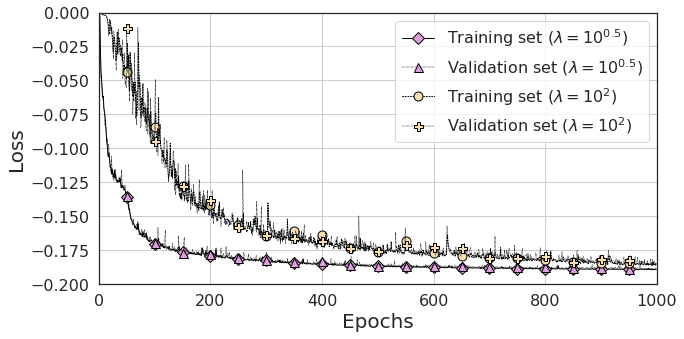

In [ ]:
plot_learning_curve('Model loss', Loss_data, val_Loss_data, 'Loss', [0,1000], [-0.20,0], LD, LR, '/Results_sigma7_VF/Curve/')

In [ ]:
plot_learning_curve('Primary network violation', V_Qos_data, val_V_Qos_data, 'Outage (%)', [0,1000], [-1,15], LD, LR, '/Results_sigma7_VF/Curve/')

In [ ]:
plot_learning_curve('Secondary achievable rate', Throughput_data,val_Throughput_data, r'Rate $(bit/s/Hz)$', [0,1000], [0,0.2], LD, LR,'/Results_sigma7_VF/Curve/')

In [ ]:
plot_learning_curve('Instantaneous primary acheivable rate degradation', Rp_degradation_data, val_Rp_degradation_data, 'Mean $\ D_{i}$ (%)', [0,1000], [0,25], LD, LR, '/Results_sigma7_VF/Curve/')

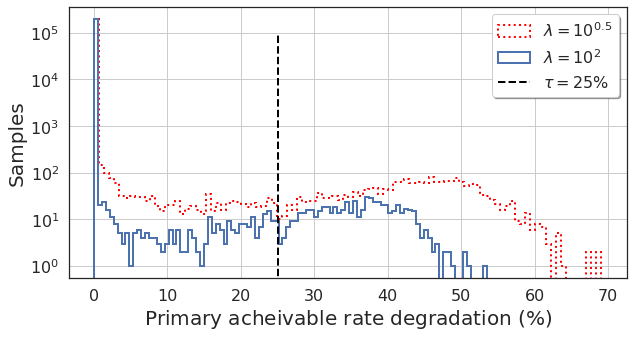

In [ ]:
def Pdd_Hist(Grp, Gpp, Gsp, Alpha, Pr, Ps, Alpha2, Pr2, Ps2):
  """
    Parameters:
      Grp: Channel Gain between relay and primary receiver.
      Gpp: Channel Gain between primary transmitter and primary receiver. 
      Gsp: Channel Gain between secondary transmitter and primary receiver.
      Alpha: Array containing Alpha values.
      Pr: Array containing Power of relay.
      Ps: Array containing Power of secondary network.
    Returns:
      histogram for Primary debit degradation 
  """
  sns.set(style='white')
  plt.rcParams["figure.figsize"] = (10,5)
  
  res = pdd(Grp, Gpp, Gsp ,Alpha, Pr, Ps)*100
  res2 = pdd(Grp, Gpp, Gsp ,Alpha2, Pr2, Ps2)*100

  #fig, ax = plt.subplots(1) # Creates figure fig and add an axes, ax.
  xs = np.linspace(1, 21, 10**5)

  plt.vlines(x=25, ymin=0, ymax=len(xs), colors='black', linestyles='--', lw=2, label=r'$\tau = 25\%$')


  plt.hist(res, 100, histtype='step', ls=':', lw = 2 , color='red',label='$\lambda = 10^{0.5}$')
  plt.hist(res2, 100, histtype='step', ls='-',  lw = 2, label='$\lambda = 10^{2}$')
  
  fig = plt.figure(1)
  #plt.xlim((-1,40))
  plt.grid()
  plt.yscale('log')
  plt.xlabel('Primary acheivable rate degradation ($\%$)', fontsize= 20)
  plt.ylabel('Samples', fontsize= 20)
  plt.legend(loc='best')
  #plt.annotate(r"$\lambda$ = "+'$'+Lambda_value.replace('_','^{')+'}$', xy=(0.05,0.9),xycoords='axes fraction',
  #           fontsize=14)

  lgd = plt.legend(loc='best',
        fancybox=True, shadow=True, fontsize= 16)#title="Learning rate"
  
  plt.xticks(fontsize=16) 
  plt.yticks(fontsize=16) 

  fig.savefig('_vf''.pdf', bbox_extra_artists=(lgd,), bbox_inches='tight')
  plt.show()
  plt.ion()
  plt.pause(1)
  plt.close()  



LD = {'10_-1':10**-1,'10_-0.75':10**-0.75,'10_-0.5':10**-0.5,'10_-0.25':10**-0.25,'10_0':10**0,'10_0.25':10**0.25,'10_0.5':10**0.5,'10_0.75':10**0.75,'10_1':10**1,'10_1.25':10**1.25,'10_1.5':10**1.5,'10_1.75':10**1.75,'10_2':10**2}

LR = {'10_-4':10**-4}
model = tf.keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/CodeVF/model_train_VF_S7_D10/Lambda = 10_0.5/weights/10_-4.h5', custom_objects={'DF_loss':loss_DF(Lambda,tau),'Primary_Achievable_Rate_Degradation':Primary_Achievable_Rate_Degradation,'Primary_ARDP':Primary_ARD_Percentage,'throughput':Achievable_Rate(tau),'V_Qos':QoS_Violation(tau), "custom_sigmoid":custom_sigmoid})
model2 = tf.keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/CodeVF/model_train_VF_S7_D10/Lambda = 10_2/weights/10_-4.h5', custom_objects={'DF_loss':loss_DF(Lambda,tau),'Primary_Achievable_Rate_Degradation':Primary_Achievable_Rate_Degradation,'Primary_ARDP':Primary_ARD_Percentage,'throughput':Achievable_Rate(tau),'V_Qos':QoS_Violation(tau), "custom_sigmoid":custom_sigmoid})

##### Evaluation on train set #####
predictions1 = model.predict(x_test)
predictions2 = model2.predict(x_test)

Pdd_Hist(x_test[:,0], x_test[:,1], x_test[:,6], predictions1[:,0], predictions1[:,1], predictions1[:,2], predictions2[:,0], predictions2[:,1], predictions2[:,2])
      

In [ ]:
import numpy as np
import cv2
image1 = cv2.imread('RAG.png')
image2 = cv2.imread('_vf.png')
final = np.concatenate((image1, image2), axis = 0)
cv2.imwrite('final.png', final)


ValueError: ignored

In [ ]:
pdd(x_test[:,0], x_test[:,1], x_test[:,6], predictions1[:,0], predictions1[:,1], predictions1[:,2])*100


In [ ]:
res

In [ ]:
import tensorflow as tf
tf.version.VERSION
